Import packages and setup

In [1]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

import cdt
cdt.SETTINGS.rpath = r'C:\Program Files\R\R-4.2.2\bin\Rscript'
from cdt.causality.graph import GES

C:\Users\prata\miniconda3\envs\default\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


Load dataset

In [2]:
def load_data(url):
    df = pd.read_csv(url, index_col=0)
    X = df.loc[:, df.columns != 'Churn Value']
    y = df.loc[:, df.columns == 'Churn Value']
    return df, X, y

df, X_train, y_train = load_data('https://raw.githubusercontent.com/prat-man/CSE-572-Data-Mining/main/data/train_data.csv')

Define features and outcomes

In [3]:
features = X_train.columns.tolist()
outcomes = y_train.columns.tolist()

Discover causal structures

In [4]:
model = GES()
skeleton = nx.Graph(df.cov())
model_graph = model.predict(df, skeleton)

Detect relevant nodes and edges

In [5]:
relevant_features = set()
relevant_nodes = set()
relevant_edges = set()

for feature in features:
    for outcome in outcomes:
        if model_graph.has_edge(feature, outcome):
            relevant_features.add(feature)
            relevant_nodes.add(feature)
            relevant_nodes.add(outcome)
            relevant_edges.add((feature, outcome))

for feature in sorted(relevant_features):
    print(feature)

Internet Service_DSL
Multiple Lines_No
Online Security_No
Online Security_No internet service
Partner_Yes
Payment Method_Bank transfer (automatic)
Payment Method_Mailed check
Streaming Movies_No


Draw the causal graph

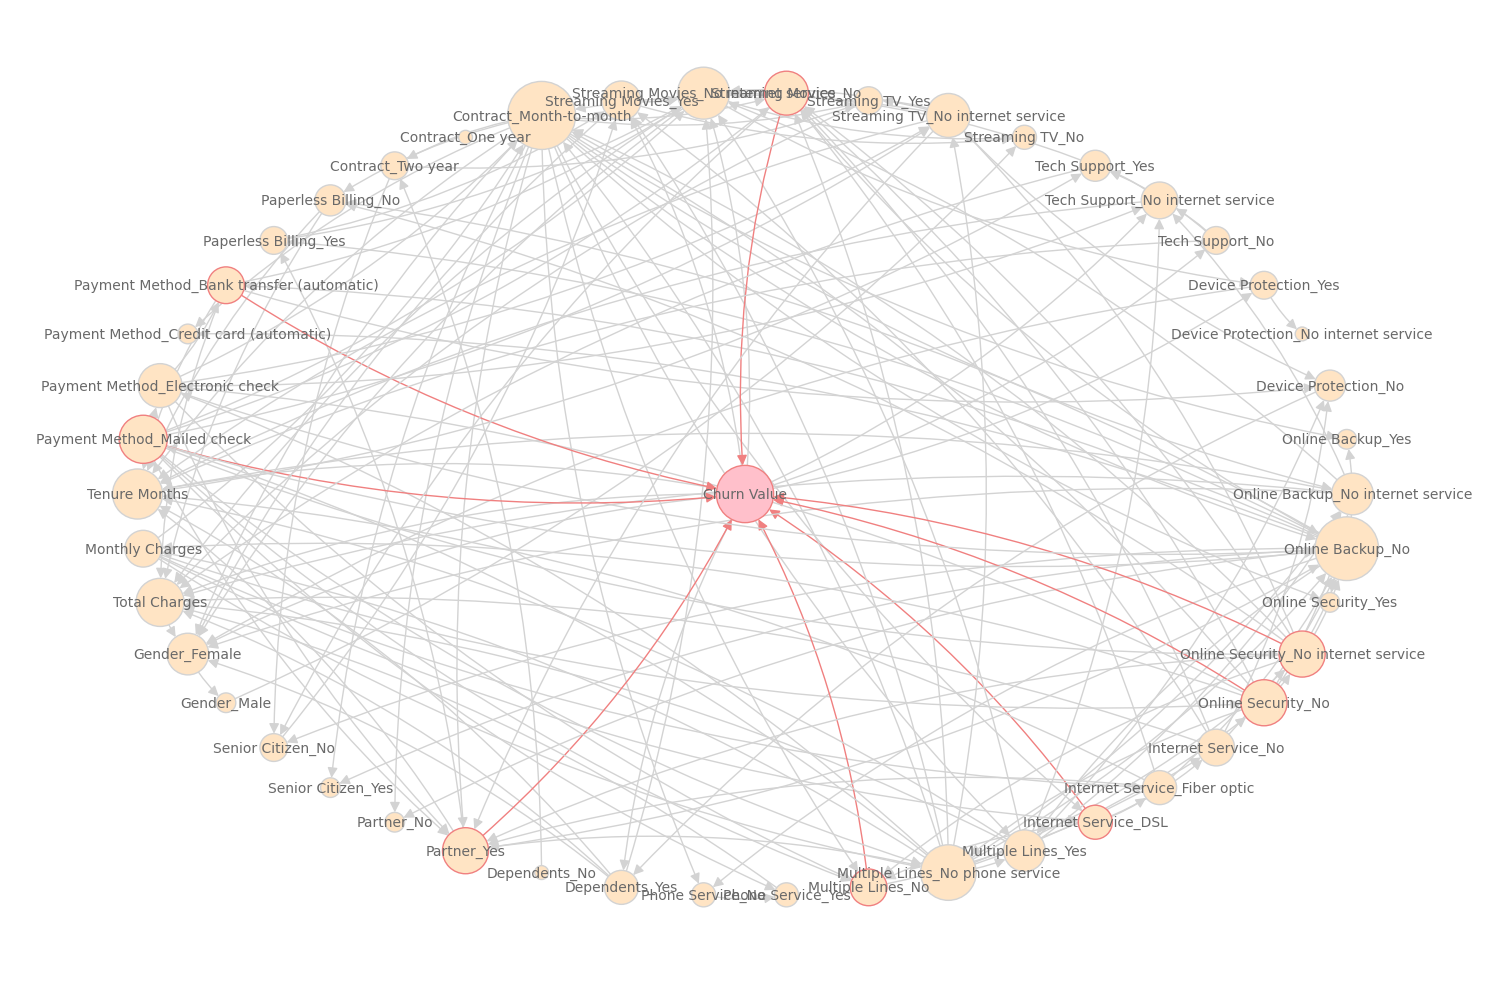

In [12]:
fig = plt.figure(figsize=(15, 10))
for i in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[i].set_visible(False)

degrees = model_graph.degree()
node_colors = ['pink' if node in outcomes else 'bisque' for node in model_graph.nodes]
node_sizes = [max(v, 1) * 100 for k, v in degrees]
node_edge_colors = ['lightcoral' if node in relevant_nodes else 'lightgray' for node in model_graph.nodes]
edge_colors = ['lightcoral' if edge in relevant_edges else 'lightgray' for edge in model_graph.edges]
pos = nx.shell_layout(model_graph, [outcomes, features])

nx.draw_networkx(model_graph,
                 pos=pos,
                 connectionstyle="arc3,rad=0.1",
                 node_color=node_colors,
                 node_size=node_sizes,
                 edgecolors=node_edge_colors,
                 edge_color=edge_colors,
                 font_size=10,
                 font_color='dimgray',
                 arrowsize=15)

plt.tight_layout()
plt.show()
# plt.savefig('graph.png', dpi=300)